In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_pipeline_data(length=1000, leak_prob=0.05, noise_std=0.02):
    np.random.seed(42)
    pressure = np.linspace(10, 5, length) + np.random.normal(0, noise_std, length)  # Decreasing pressure
    flow_rate = np.linspace(100, 80, length) + np.random.normal(0, noise_std*100, length)
    
    leak = np.zeros(length)
    
    for i in range(length):
        if np.random.rand() < leak_prob:
            drop = np.random.uniform(0.2, 1.0)  # sudden drop
            pressure[i:] -= drop
            flow_rate[i:] -= drop * 10
            leak[i:] = 1
            break  # simulate one major leak for simplicity

    df = pd.DataFrame({'time': np.arange(length), 'pressure': pressure, 'flow_rate': flow_rate, 'leak': leak})
    return df

df = generate_pipeline_data()
df.to_csv("pipeline_data.csv", index=False)
df.head()


,time,pressure,flow_rate,leak
0,0,10.009934,102.798711,0.0
1,1,9.992230,101.829247,0.0
2,2,10.002944,100.079221,0.0
3,3,10.015446,98.646066,0.0
4,4,9.975297,101.316367,0.0


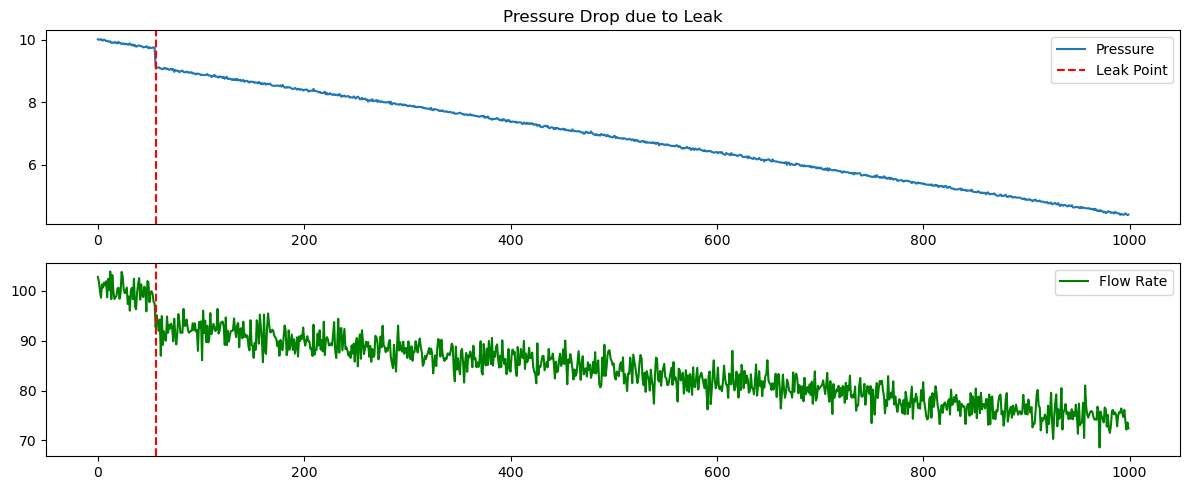

In [3]:
plt.figure(figsize=(12, 5))
plt.subplot(2,1,1)
plt.plot(df['pressure'], label='Pressure')
plt.axvline(df[df['leak']==1].index[0], color='red', linestyle='--', label='Leak Point')
plt.legend()
plt.title("Pressure Drop due to Leak")

plt.subplot(2,1,2)
plt.plot(df['flow_rate'], label='Flow Rate', color='green')
plt.axvline(df[df['leak']==1].index[0], color='red', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

X = df[['pressure', 'flow_rate']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = IsolationForest(contamination=0.01)
df['anomaly'] = model.fit_predict(X_scaled)

# Map output to 0 (normal) and 1 (anomaly)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(df['leak'], df['anomaly']))


              precision    recall  f1-score   support

         0.0       0.05      0.84      0.09        56
         1.0       0.10      0.00      0.00       944

    accuracy                           0.05      1000
   macro avg       0.07      0.42      0.05      1000
weighted avg       0.10      0.05      0.01      1000



In [ ]:
import dash
from dash import html, dcc
import plotly.graph_objs as go
import pandas as pd

# Load data
df = pd.read_csv("pipeline_data.csv")

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "Leak Detection Dashboard"

# Create layout
app.layout = html.Div([
    html.H1("📡 Leak Detection in Pipelines"),
    
    dcc.Graph(
        id='pressure-flow-graph',
        figure={
            'data': [
                go.Scatter(x=df['time'], y=df['pressure'], mode='lines', name='Pressure'),
                go.Scatter(x=df['time'], y=df['flow_rate'], mode='lines', name='Flow Rate'),
            ],
            'layout': go.Layout(title='Pressure and Flow Rate', xaxis={'title': 'Time'}, yaxis={'title': 'Value'})
        }
    ),

    html.H3("Detected Leak and Anomalies"),

    html.Div([
        f"🚨 Leak Detected at index: {df[df['leak']==1].index[0]}" if df['leak'].any() else "✅ No Leak Detected"
    ]),

    html.Div([
        f"⚠️ {df['anomaly'].sum()} anomalies detected." if 'anomaly' in df.columns else ""
    ])
])

# Run app
if __name__ == '__main__':
    app.run(debug=True)
